In [1]:
import sympy as sm
from sympy import diff, Symbol, cos,diag
from scipy.integrate import solve_ivp,OdeSolver,odeint
import numpy as np
from sympy.physics.mechanics import dynamicsymbols
import math
import matplotlib.pyplot as plt

In [2]:
from sympy.physics.vector import init_vprinting
init_vprinting(use_latex="mathjax", pretty_print=False)

In [3]:
m1, m2, l1, l2, gty ,tau1, tau2, c1, c2, L, I1, I2 = sm.symbols('m1 m2 l1 l2 g tau1 tau2 c1 c2 L I1 I2', real =True)
rho, V, Cd, D = sm.symbols('rho V C_d D', real =True)
t = Symbol('t')
theta1, theta2 = dynamicsymbols('theta1 theta2')
theta1d = dynamicsymbols('theta1',1)
theta2d = dynamicsymbols('theta2',1)
theta1dd = dynamicsymbols('theta1',2)
theta2dd = dynamicsymbols('theta2',2)
gty, m1, m2, l1, l2, theta1, theta2, theta1d, theta2d, theta1dd, theta2dd, tau1, tau2,I1, I2,rho,V,Cd,D

(g, m1, m2, l1, l2, theta1, theta2, theta1', theta2', theta1'', theta2'', tau1, tau2, I1, I2, rho, V, C_d, D)

In [4]:
x1 = l1*sm.cos(theta1)
y1 = l1*sm.sin(theta1)
x2 = l1*sm.cos(theta1) + l2*sm.cos(theta2)
y2 = l1*sm.sin(theta1) + l2*sm.sin(theta2)

x1_dot = sm.diff(x1,t)
x2_dot = sm.diff(x2,t)
y1_dot = sm.diff(y1,t)
y2_dot = sm.diff(y2,t)

x1_dot , x2_dot, y1_dot , y2_dot

(-l1*sin(theta1)*theta1', -l1*sin(theta1)*theta1' - l2*sin(theta2)*theta2', l1*cos(theta1)*theta1', l1*cos(theta1)*theta1' + l2*cos(theta2)*theta2')

# dynamic modeling on manipulator without constraint using lagrange equation

In [5]:
# kinetic energy
ke = (sm.Rational(1/2))*m1*(x1_dot**2)
ke += (sm.Rational(1/2))*m1*(y1_dot**2)
ke += (sm.Rational(1/2))*m2*(x2_dot**2)
ke += (sm.Rational(1/2))*m2*(y2_dot**2)
sm.simplify(ke)

l1**2*m1*theta1'**2/2 + l1**2*m2*theta1'**2/2 + l1*l2*m2*cos(theta1 - theta2)*theta1'*theta2' + l2**2*m2*theta2'**2/2

In [6]:
# potential energy
pe = m1*gty*y1
pe += m2*gty*y2
sm.expand(pe)

g*l1*m1*sin(theta1) + g*l1*m2*sin(theta1) + g*l2*m2*sin(theta2)

In [7]:
# the lagrangian equation
Ls = ke - pe

In [8]:
# force applied at joint 1
f1 = sm.diff(sm.diff(Ls,theta1d),t) - sm.diff(Ls,theta1)
f1sim = sm.expand(sm.simplify(f1))
f1sim

g*l1*m1*cos(theta1) + g*l1*m2*cos(theta1) + l1**2*m1*theta1'' + l1**2*m2*theta1'' + l1*l2*m2*sin(theta1 - theta2)*theta2'**2 + l1*l2*m2*cos(theta1 - theta2)*theta2''

In [9]:
# force applied at joint 2
f2 = sm.diff(sm.diff(Ls,theta2d),t) - sm.diff(Ls,theta2)
f2sim = sm.expand(sm.simplify(f2))
f2sim

g*l2*m2*cos(theta2) - l1*l2*m2*sin(theta1 - theta2)*theta1'**2 + l1*l2*m2*cos(theta1 - theta2)*theta1'' + l2**2*m2*theta2''

In [10]:
#inertia term
it11 = f1sim.coeff(theta1dd) * theta1dd
it12 = f2sim.coeff(theta1dd) * theta1dd

it21 = f1sim.coeff(theta2dd) * theta2dd
it22 = f2sim.coeff(theta2dd) * theta2dd

m11 = f1sim.coeff(theta1dd)
m12 = f2sim.coeff(theta1dd)

m21 = f1sim.coeff(theta2dd)
m22 = f2sim.coeff(theta2dd)

M = sm.Matrix([[m11, m21], [m12, m22]])
M

Matrix([
[          l1**2*m1 + l1**2*m2, l1*l2*m2*cos(theta1 - theta2)],
[l1*l2*m2*cos(theta1 - theta2),                      l2**2*m2]])

In [11]:
#centrifugal / Coriolis force term,
C11 = (f1sim.coeff(theta1d * theta2d)*theta1d * theta2d) + (f1sim.coeff(theta1d * theta1d)* theta1d * theta1d) + (f1sim.coeff(theta2d * theta2d)*theta2d * theta2d)
C12 = (f2sim.coeff(theta1d * theta2d)*theta1d * theta2d) + (f2sim.coeff(theta1d * theta1d)* theta1d * theta1d) + (f2sim.coeff(theta2d * theta2d)*theta2d * theta2d)

C = sm.Matrix([[C11], [C12]])
C

Matrix([
[ l1*l2*m2*sin(theta1 - theta2)*theta2'**2],
[-l1*l2*m2*sin(theta1 - theta2)*theta1'**2]])

In [12]:
# gravity term
g1 = f1sim - sm.expand(it11) - sm.expand(it21) - sm.expand(C11)
g2 = f2sim - sm.expand(it12) - sm.expand(it22) - sm.expand(C12)
G = sm.Matrix([g1, g2])
G

Matrix([
[g*l1*m1*cos(theta1) + g*l1*m2*cos(theta1)],
[                      g*l2*m2*cos(theta2)]])

In [13]:
tau = sm.Matrix([[tau1], [tau2]])
tau

Matrix([
[tau1],
[tau2]])

In [30]:
# added friction
d = diag(c1,c2) * sm.Matrix([theta1d, theta2d])
F = tau -C -G+ d
F

Matrix([
[c1*theta1' - g*l1*m1*cos(theta1) - g*l1*m2*cos(theta1) - l1*l2*m2*sin(theta1 - theta2)*theta2'**2 + tau1],
[                      c2*theta2' - g*l2*m2*cos(theta2) + l1*l2*m2*sin(theta1 - theta2)*theta1'**2 + tau2]])

In [24]:
#  hydrodynamic forces

#added mass 
#For simplicity, we can approximate the geometry of the
#designed manipulator links as cylinders. Then we can easily
#obtain the mass inertia matrix for each link through the
#equations

Ma = diag(1, 2, 3)
Ma

Matrix([
[1, 0, 0],
[0, 2, 0],
[0, 0, 3]])

In [36]:
#Drag force 
n=2
#Dg=0
#[Dg := Dg + Cd*((l1*theta1)/D)*0.5*rho*D*l1^3 for x in range(n-1)]

In [29]:
#Buoyancy
B = rho * gty * V
B

V*g*rho

In [ ]:
# added unknown payload

# Dynamic modeling subject to constraint

In [15]:
endefX = x2 - L #endeffector x trajectory
endefY = y2 - 0.2*(1-sm.cos(t)) #endeffector y trajectory
endefX, endefY

(-L + l1*cos(theta1) + l2*cos(theta2), l1*sin(theta1) + l2*sin(theta2) + 0.2*cos(t) - 0.2)

In [16]:
# get second order form
endefXdd = sm.diff(sm.diff(endefX,t),t)
endefYdd = sm.diff(sm.diff(endefY,t),t)
endefXdd, endefYdd

(-l1*sin(theta1)*theta1'' - l1*cos(theta1)*theta1'**2 - l2*sin(theta2)*theta2'' - l2*cos(theta2)*theta2'**2, -l1*sin(theta1)*theta1'**2 + l1*cos(theta1)*theta1'' - l2*sin(theta2)*theta2'**2 + l2*cos(theta2)*theta2'' - 0.2*cos(t))

In [17]:
A11 = endefXdd.coeff(theta1dd)
A21 = endefXdd.coeff(theta2dd)

A12 = endefYdd.coeff(theta1dd)
A22 = endefYdd.coeff(theta2dd)

A = sm.Matrix([[A11, A21], [A12, A22]])
A

Matrix([
[-l1*sin(theta1), -l2*sin(theta2)],
[ l1*cos(theta1),  l2*cos(theta2)]])

In [18]:
b1 = endefXdd - sm.expand(A11)*theta1dd - sm.expand(A21)*theta2dd
b2 = endefYdd - sm.expand(A12)*theta1dd - sm.expand(A22)*theta2dd
b = -sm.Matrix([b1,b2])
b

Matrix([
[             l1*cos(theta1)*theta1'**2 + l2*cos(theta2)*theta2'**2],
[l1*sin(theta1)*theta1'**2 + l2*sin(theta2)*theta2'**2 + 0.2*cos(t)]])

# solve system

In [19]:
# ode func for scipy solve_ivp
theta1d_func = sm.lambdify(theta1d, theta1d)
theta2d_func = sm.lambdify(theta2d, theta2d)

t_span = (0, 50)
g_ = 0
m1_ = 1
m2_ = 1
l1_ = 1
l2_ = 1
tq1_ = 0
tq2_ = 0
c1_ = 0.5
c2_ = 0.5
y0 = [30,0,-30,0]  # Initial state of the system


In [20]:
h_sn = (A*(M**(-1/2))).subs({gty: g_,l1: l1_, l2: l2_, m1: m1_, m2: m2_, c1:c1_,c2:c2_,tau1:tq1_,tau2:tq2_})
j_sn = (M**(1/2)).subs({gty: g_,l1: l1_, l2: l2_, m1: m1_, m2: m2_, c1:c1_,c2:c2_,tau1:tq1_,tau2:tq2_})
k_sn = (b-(A*(M.inv()*F))).subs({gty: g_,l1: l1_, l2: l2_, m1: m1_, m2: m2_, c1:c1_,c2:c2_,tau1:tq1_,tau2:tq2_})
F_sn = F.subs({gty: g_,l1: l1_, l2: l2_, m1: m1_, m2: m2_, c1:c1_,c2:c2_,tau1:tq1_,tau2:tq2_})
M_sn = M.subs({gty: g_,l1: l1_, l2: l2_, m1: m1_, m2: m2_, c1:c1_,c2:c2_,tau1:tq1_,tau2:tq2_})

In [21]:
def dSdt(t,S):
    thet1_, dtheta1_, thet2_, dtheta2_ = S
    
    print(t, S)
    
    h_n = h_sn.subs({Symbol('t'):t,theta1:thet1_ ,theta2:thet2_,theta1d:dtheta1_, theta2d:dtheta2_}).evalf()
    j_n = j_sn.subs({Symbol('t'):t,theta1:thet1_ ,theta2:thet2_,theta1d:dtheta1_, theta2d:dtheta2_}).evalf()
    k_n = k_sn.subs({Symbol('t'):t,theta1:thet1_ ,theta2:thet2_,theta1d:dtheta1_, theta2d:dtheta2_}).evalf()
    psu_i = h_n.pinv()
    Fc = (j_n * psu_i * k_n)
    F_n = F_sn.subs({Symbol('t'):t,theta1:thet1_ ,theta2:thet2_,theta1d:dtheta1_, theta2d:dtheta2_}).evalf()
    rf = F_n + Fc
    ra = M_sn.inv().subs({Symbol('t'):t,theta1:thet1_ ,theta2:thet2_,theta1d:dtheta1_, theta2d:dtheta2_}).evalf() * rf
    return [
        theta1d_func(dtheta1_),
        ra[0],
        theta2d_func(dtheta2_),
        ra[1]
    ]

In [22]:
solve_ivp_rk45 = solve_ivp(dSdt,t_span, y0, method="LSODA")

0.0 [ 30.   0. -30.   0.]
4.8778591379596646e-05 [ 3.00000000e+01  3.16227766e-05 -3.00000000e+01  3.16227766e-05]
4.8778591379596646e-05 [ 3.00000000e+01  3.16227766e-05 -3.00000000e+01  3.16227765e-05]
9.755718275919329e-05 [ 3.00000000e+01  6.32455531e-05 -3.00000000e+01  6.32455531e-05]
9.755718275919329e-05 [ 3.00000000e+01  6.32455530e-05 -3.00000000e+01  6.32455529e-05]
0.0002869235332408346 [ 3.00000000e+01  1.86010266e-04 -3.00000000e+01  1.86010264e-04]
0.0002869235332408346 [ 3.00000000e+01  1.86010265e-04 -3.00000000e+01  1.86010263e-04]
0.0004762898837224759 [ 3.00000001e+01  3.08774973e-04 -2.99999999e+01  3.08774967e-04]
0.0004762898837224759 [ 3.00000001e+01  3.08774971e-04 -2.99999999e+01  3.08774964e-04]
0.0006656562342041172 [ 3.00000001e+01  4.31539672e-04 -2.99999999e+01  4.31539653e-04]
0.0006656562342041172 [ 3.00000001e+01  4.31539671e-04 -2.99999999e+01  4.31539650e-04]
0.0008550225846857585 [ 3.00000002e+01  5.54304361e-04 -2.99999998e+01  5.54304320e-04]
0.00

2.273254356879058 [ 30.89190675   0.28969082 -29.25307238   0.17531837]
2.4274036340134346 [ 30.93274883   0.23575545 -29.2288996    0.13421433]
2.5815529111478113 [ 30.96520078   0.18354369 -29.21080511   0.09916017]
2.5503358026155487 [ 30.95916617   0.1942233  -29.21417471   0.10614169]
2.673267971217663 [ 30.9804447    0.1533427  -29.20278285   0.08099465]
2.796200139819777 [ 30.99673514   0.11291705 -29.19434021   0.05808075]
2.919132308421891 [ 31.00814773   0.07283101 -29.18852368   0.03681749]
3.042064477024005 [ 3.10146692e+01  3.29631333e-02 -2.91852208e+01  1.66456416e-02]
3.2354623500218382 [ 3.10150266e+01 -2.95853732e-02 -2.91849499e+01 -1.43048650e-02]
3.2354623500218382 [ 3.10150270e+01 -2.95853732e-02 -2.91849499e+01 -1.43048650e-02]
3.2354623500218382 [ 3.10150266e+01 -2.95853727e-02 -2.91849499e+01 -1.43048650e-02]
3.2354623500218382 [ 3.10150266e+01 -2.95853732e-02 -2.91849494e+01 -1.43048650e-02]
3.2354623500218382 [ 3.10150266e+01 -2.95853732e-02 -2.91849499e+01 -

11.56513925250555 [ 30.30374141  -0.5294875  -29.70700719  -0.47906367]
11.56513925250555 [ 30.30374141  -0.5294875  -29.70700675  -0.47906367]
11.56513925250555 [ 30.30374141  -0.5294875  -29.70700719  -0.47906366]
11.627429793149492 [ 30.2712287   -0.51374813 -29.73659984  -0.47030335]
11.689720333793435 [ 30.23980721  -0.49446773 -29.76552295  -0.45762936]
11.752010874437378 [ 30.20969173  -0.47183543 -29.79353667  -0.44114344]
11.91473905356145 [ 30.13870422  -0.39842571 -29.86070753  -0.38103893]
11.91473905356145 [ 30.13870467  -0.39842571 -29.86070753  -0.38103893]
11.91473905356145 [ 30.13870422  -0.3984257  -29.86070753  -0.38103893]
11.91473905356145 [ 30.13870422  -0.39842571 -29.86070709  -0.38103893]
11.91473905356145 [ 30.13870422  -0.39842571 -29.86070753  -0.38103892]
11.91473905356145 [ 30.13853968  -0.39883213 -29.86083737  -0.3816174 ]
12.077467232685521 [ 30.0808778   -0.31071133 -29.9164659   -0.30257497]
12.077467232685521 [ 30.08066582  -0.30981786 -29.91673955  

15.836761825857046 [ 3.10229040e+01 -4.03349914e-02 -2.91757830e+01 -1.93272971e-02]
15.836761825857046 [ 3.10229044e+01 -4.03349914e-02 -2.91757830e+01 -1.93272971e-02]
15.836761825857046 [ 3.10229040e+01 -4.03349908e-02 -2.91757830e+01 -1.93272971e-02]
15.836761825857046 [ 3.10229040e+01 -4.03349914e-02 -2.91757826e+01 -1.93272971e-02]
15.836761825857046 [ 3.10229040e+01 -4.03349914e-02 -2.91757830e+01 -1.93272968e-02]
15.87173431505074 [ 3.10212966e+01 -5.15913064e-02 -2.91765562e+01 -2.49067859e-02]
15.906706804244433 [ 3.10192952e+01 -6.28627998e-02 -2.91775257e+01 -3.05537347e-02]
15.941679293438126 [ 31.01689938  -0.07415297 -29.17869428  -0.03628279]
16.104191291909927 [ 31.00057291  -0.12696063 -29.18680998  -0.06440372]
16.104191291909927 [ 31.00057337  -0.12696063 -29.18680998  -0.06440372]
16.104191291909927 [ 31.00057291  -0.12696063 -29.18680998  -0.06440372]
16.104191291909927 [ 31.00057291  -0.12696063 -29.18680954  -0.06440372]
16.104191291909927 [ 31.00057291  -0.1269

21.926106935334374 [ 3.10309239e+01  2.13965382e-02 -2.91684118e+01  1.04954015e-02]
21.926106935334374 [ 3.10308994e+01  2.13481247e-02 -2.91685168e+01  1.04196509e-02]
22.060456250515397 [ 3.10309037e+01 -2.15927994e-02 -2.91684227e+01 -1.02481147e-02]
22.19480556569642 [ 31.02510563  -0.06464536 -29.17123835  -0.03137941]
22.329154880877443 [ 31.01350667  -0.10798042 -29.17696702  -0.05375023]
22.463504196058466 [ 30.99605613  -0.15179253 -29.18582882  -0.07816729]
22.641766792414806 [ 30.96375834  -0.21094796 -29.20290318  -0.11502479]
22.641766792414806 [ 30.9637588   -0.21094796 -29.20290318  -0.11502479]
22.641766792414806 [ 30.96375834  -0.21094796 -29.20290318  -0.11502479]
22.641766792414806 [ 30.96375834  -0.21094796 -29.20290275  -0.11502479]
22.641766792414806 [ 30.96375834  -0.21094796 -29.20290318  -0.11502479]
22.641766792414806 [ 30.96371298  -0.21087242 -29.20311676  -0.11487869]
22.820029388771147 [ 30.92079373  -0.27140538 -29.2271389   -0.15819595]
22.8200293887711

28.30138084302519 [ 3.10409537e+01 -7.21098256e-03 -2.91585843e+01 -3.05517488e-03]
28.291154140345434 [ 3.10410110e+01 -3.96809204e-03 -2.91585604e+01 -1.52431788e-03]
28.291154140345434 [ 3.10410115e+01 -3.96809204e-03 -2.91585604e+01 -1.52431788e-03]
28.291154140345434 [ 3.10410110e+01 -3.96809198e-03 -2.91585604e+01 -1.52431788e-03]
28.291154140345434 [ 3.10410110e+01 -3.96809204e-03 -2.91585599e+01 -1.52431788e-03]
28.291154140345434 [ 3.10410110e+01 -3.96809204e-03 -2.91585604e+01 -1.52431786e-03]
28.291154140345434 [ 3.10410111e+01 -3.96976795e-03 -2.91585599e+01 -1.53127225e-03]
28.31529490118033 [ 3.10408229e+01 -1.16272629e-02 -2.91586407e+01 -5.15581747e-03]
28.31529490118033 [ 3.10408229e+01 -1.16286284e-02 -2.91586406e+01 -5.16140610e-03]
28.339435662015227 [ 3.10404497e+01 -1.92874068e-02 -2.91588091e+01 -8.79351326e-03]
28.38592164009859 [ 3.10392102e+01 -3.40437417e-02 -2.91593810e+01 -1.58286456e-02]
28.38592164009859 [ 3.10392107e+01 -3.40437417e-02 -2.91593810e+01 -1

32.32664295001364 [ 30.28567175   0.51631943 -29.71349588   0.4710402 ]
32.32664295001364 [ 30.28567175   0.51631943 -29.71349632   0.4710402 ]
32.32664295001364 [ 30.28509283   0.51655324 -29.71404922   0.47181732]
32.48488215868946 [ 30.3704208    0.55024781 -29.63731437   0.48642367]
32.48488215868946 [ 30.36977524   0.55161086 -29.63784215   0.48847631]
32.45614709921176 [ 30.35444686   0.54618916 -29.65149079   0.4860459 ]
32.58565124840988 [ 30.426186     0.55961244 -29.58848811   0.48383734]
32.715155397608 [ 30.49869515   0.5573264  -29.52676177   0.46625596]
32.84465954680612 [ 30.57006909   0.54148031 -29.46806988   0.43649205]
32.97416369600424 [ 30.63867489   0.5147502  -29.41381303   0.39814044]
33.10366784520236 [ 30.70326629   0.48000885 -29.36489584   0.35478508]
33.23317199440048 [ 30.76296841   0.43992242 -29.32177049   0.30957467]
33.376550484333215 [ 30.82262165   0.3920845  -29.28096579   0.26050065]
33.51992897426595 [ 30.87532631   0.34258212 -29.24694641   0.214

36.735803023726135 [ 30.32260275  -0.52485971 -29.67886382  -0.47245856]
36.735803023726135 [ 30.32379769  -0.52814323 -29.67713349  -0.47525104]
36.68132778768396 [ 30.35212143  -0.5374962  -29.65221002  -0.47851202]
36.68132778768396 [ 30.35268422  -0.53888751 -29.65139982  -0.47965572]
36.850167515347735 [ 30.26470211  -0.49156949 -29.73127918  -0.45143079]
36.80626662354732 [ 30.28692661  -0.50709748 -29.71079051  -0.46222898]
36.80626662354732 [ 30.28692706  -0.50709748 -29.71079051  -0.46222898]
36.80626662354732 [ 30.28692661  -0.50709747 -29.71079051  -0.46222898]
36.80626662354732 [ 30.28692661  -0.50709748 -29.71079006  -0.46222898]
36.80626662354732 [ 30.28692661  -0.50709748 -29.71079051  -0.46222898]
36.80626662354732 [ 30.28718747  -0.5084794  -29.71037113  -0.46356791]
36.931205459410684 [ 30.22629351  -0.46204377 -29.7665667   -0.42983361]
36.931205459410684 [ 30.22632143  -0.46339418 -29.76641813  -0.43129478]
37.056144295274045 [ 30.17203098  -0.40432579 -29.81745845 

40.93518664102579 [ 3.10560520e+01 -2.87380123e-02 -2.91468308e+01 -1.36640305e-02]
40.93518664102579 [ 3.10560520e+01 -2.87380127e-02 -2.91468304e+01 -1.36640305e-02]
40.93518664102579 [ 3.10560520e+01 -2.87380127e-02 -2.91468308e+01 -1.36640303e-02]
40.93518664102579 [ 3.10560519e+01 -2.87390922e-02 -2.91468311e+01 -1.36686228e-02]
40.97222677431597 [ 3.10547734e+01 -4.03019008e-02 -2.91474363e+01 -1.90395737e-02]
41.009266907606154 [ 3.10530663e+01 -5.18769193e-02 -2.91482418e+01 -2.44680043e-02]
41.04630704089634 [ 3.10509302e+01 -6.34684204e-02 -2.91492499e+01 -2.99720874e-02]
41.14153851242115 [ 31.04346449  -0.09337639 -29.15278923  -0.04459891]
41.14153851242115 [ 31.04346495  -0.09337639 -29.15278923  -0.04459891]
41.14153851242115 [ 31.04346449  -0.09337639 -29.15278923  -0.04459891]
41.14153851242115 [ 31.04346449  -0.09337639 -29.15278879  -0.04459891]
41.14153851242115 [ 31.04346449  -0.09337639 -29.15278923  -0.04459891]
41.23676998394596 [ 31.03314169  -0.12348678 -29.15

45.09370438603296 [ 30.41719963   0.54794743 -29.59572895   0.47502597]
45.24429853783526 [ 30.50034066   0.55061656 -29.52493535   0.45966318]
45.394892689637565 [ 30.58244392   0.53456593 -29.45777751   0.42718496]
45.54548684143987 [ 30.66087152   0.50373298 -29.39656487   0.38298478]
45.69608099324217 [ 30.73373459   0.46238947 -29.34264336   0.33243976]
45.84667514504447 [ 30.79981702   0.41470657 -29.29653539   0.28042313]
45.997269296846774 [ 30.85845458   0.36407592 -29.25813811   0.23060989]
46.147863448649076 [ 30.90939383   0.31280472 -29.22692646   0.18525346]
46.29845760045138 [ 30.95264516   0.2621411  -29.20214344   0.14528868]
46.44905175225368 [ 30.98834674   0.212533   -29.18296716   0.11066192]
46.6174641970122 [ 31.01955848   0.15820141 -29.16719527   0.07735795]
46.78587664177071 [ 31.04162297   0.10521712 -29.15674087   0.04901233]
46.95428908652923 [ 3.10548145e+01  5.27847956e-02 -2.91507935e+01  2.36060347e-02]
46.95428908652923 [ 3.10549573e+01  5.23822891e-02

In [23]:
t = solve_ivp_rk45.t
the1 = solve_ivp_rk45.y[0]
the1d = solve_ivp_rk45.y[1]
the2 = solve_ivp_rk45.y[2]
the2d = solve_ivp_rk45.y[3]

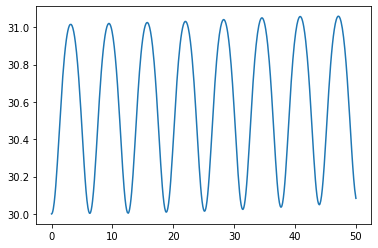

In [24]:
plt.plot(t, the1, label=f'$X_{0}(t)$')

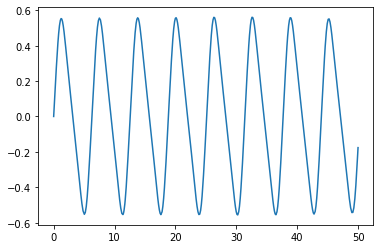

In [25]:
plt.plot(t, the1d, label=f'$X_{1}(t)$')

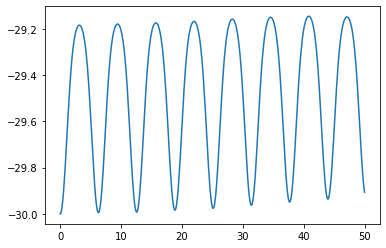

In [26]:
plt.plot(t, the2, label=f'$X_{2}(t)$')

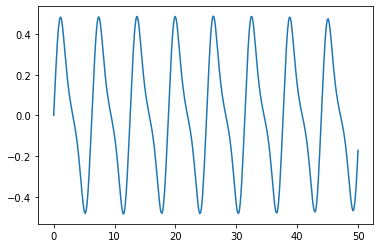

In [27]:
plt.plot(t, the2d, label=f'$X_{3}(t)$')